In [14]:
#Importing libraries
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import time, psutil
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import NaiveBayes, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns

spark = SparkSession.builder \
    .appName("TaxiTripBigDataProject") \
    .master("local[*]") \
    .getOrCreate()

In [15]:
# Load Taxi Trip dataset
taxi_df = spark.read.csv("/content/Taxi_Trip_Data_preprocessed.csv", header=True, inferSchema=True)
taxi_df.cache()
taxi_df.printSchema()
taxi_df.show(5)

root
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- duration: double (nullable = true)

+---------------+-------------+------------+-----------+------------------+
|passenger_count|trip_distance|payment_type|fare_amount|          duration|
+---------------+-------------+------------+-----------+------------------+
|              1|          3.7|        Card|       24.0|             27.95|
|              1|         2.77|        Card|       18.4|              19.2|
|              1|          3.3|        Card|       22.6|27.383333333333333|
|              1|          0.3|        Cash|        5.1|              2.55|
|              1|         0.83|        Card|        7.2|              5.25|
+---------------+-------------+------------+-----------+------------------+
only showing top 5 rows



In [16]:
taxi_df.describe(["trip_distance", "fare_amount"]).show()
taxi_df.groupBy("passenger_count").count().orderBy("count", ascending=False).show()

+-------+------------------+------------------+
|summary|     trip_distance|       fare_amount|
+-------+------------------+------------------+
|  count|           8451090|           8451090|
|   mean|1.7511353494046304|12.731798566812104|
| stddev|1.0454884511846674| 5.346808673486632|
|    min|              0.01|              0.01|
|    max|              5.23|              40.8|
+-------+------------------+------------------+

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|6587822|
|              2|1259060|
|              3| 316883|
|              4| 170241|
|              5| 117084|
+---------------+-------+



In [17]:
start = time.time()
mem_start = psutil.Process().memory_info().rss / (1024 ** 2)

# Total trips
total_trips = taxi_df.count()

# Average fare
taxi_df.selectExpr("avg(fare_amount) as average_fare").show()

# Average distance
taxi_df.selectExpr("avg(trip_distance) as avg_distance").show()

# Most common passenger count
taxi_df.groupBy("passenger_count").count().orderBy("count", ascending=False).show()

end = time.time()
mem_end = psutil.Process().memory_info().rss / (1024 ** 2)

print(f"Q3 Execution Time: {end - start:.2f} seconds")
print(f"Memory Used: {mem_end - mem_start:.2f} MB")

+------------------+
|      average_fare|
+------------------+
|12.731798566812104|
+------------------+

+------------------+
|      avg_distance|
+------------------+
|1.7511353494046304|
+------------------+

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|6587822|
|              2|1259060|
|              3| 316883|
|              4| 170241|
|              5| 117084|
+---------------+-------+

Q3 Execution Time: 4.55 seconds
Memory Used: 0.18 MB


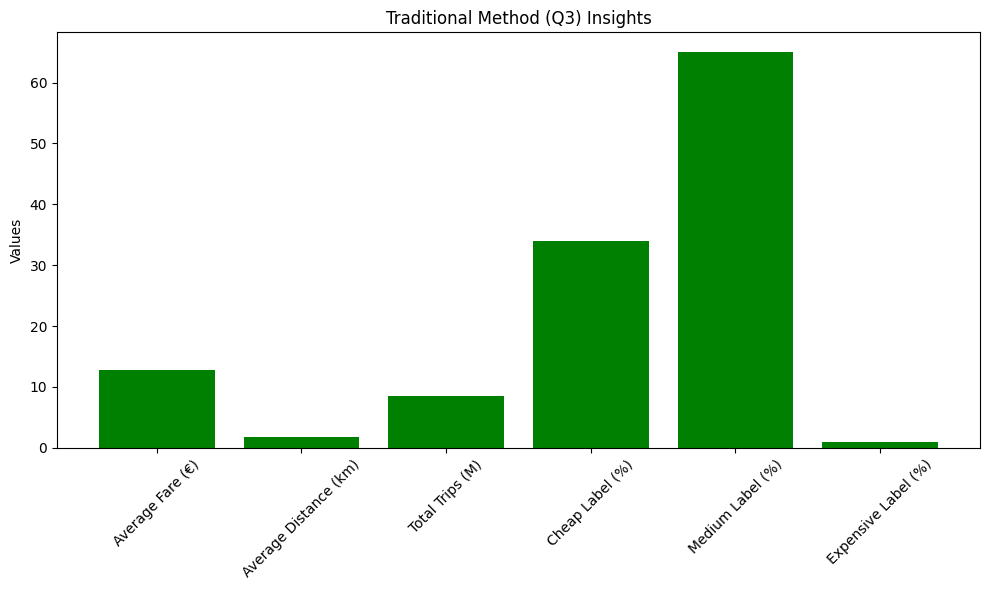

In [27]:
categories = ['Average Fare (€)', 'Average Distance (km)', 'Total Trips (M)', 'Cheap Label (%)', 'Medium Label (%)', 'Expensive Label (%)']
values = [12.73, 1.75, 8.45, 34, 65, 1]

# Creating bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, values,color='green')
plt.title("Traditional Method (Q3) Insights")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [18]:
# Create a label column based on fare amount
taxi_df = taxi_df.withColumn("trip_label", when(taxi_df["fare_amount"] < 10, "cheap")
                   .when(taxi_df["fare_amount"] < 30, "medium")
                   .otherwise("expensive"))

taxi_df.select("fare_amount", "trip_label").show(5)

+-----------+----------+
|fare_amount|trip_label|
+-----------+----------+
|       24.0|    medium|
|       18.4|    medium|
|       22.6|    medium|
|        5.1|     cheap|
|        7.2|     cheap|
+-----------+----------+
only showing top 5 rows



In [19]:
taxi_df_clean = taxi_df.dropna(subset=["trip_distance", "passenger_count", "fare_amount", "trip_label"])
assembler = VectorAssembler(inputCols=["trip_distance", "passenger_count"], outputCol="features")
label_indexer = StringIndexer(inputCol="trip_label", outputCol="label")

In [20]:
taxi_df.groupBy("trip_label").count().show()

+----------+-------+
|trip_label|  count|
+----------+-------+
| expensive|   6022|
|     cheap|2869289|
|    medium|5575779|
+----------+-------+



In [21]:
# Train/test split
(train, test) = taxi_df_clean.randomSplit([0.8, 0.2], seed=42)

models = {
    "Naive Bayes": NaiveBayes(labelCol="label", featuresCol="features"),
    "Logistic Regression": LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
}

for name, model in models.items():
    print(f"\n--- Training: {name} ---")
    pipeline = Pipeline(stages=[label_indexer, assembler, model])

    start = time.time()
    mem_start = psutil.Process().memory_info().rss / (1024 ** 2)

    fitted = pipeline.fit(train)
    predictions = fitted.transform(test)
    predictions.select("fare_amount", "trip_label", "prediction").show(3)

    end = time.time()
    mem_end = psutil.Process().memory_info().rss / (1024 ** 2)

    print(f"{name} Execution Time: {end - start:.2f} seconds")
    print(f"{name} Memory Used: {mem_end - mem_start:.2f} MB")


--- Training: Naive Bayes ---
+-----------+----------+----------+
|fare_amount|trip_label|prediction|
+-----------+----------+----------+
|        3.0|     cheap|       0.0|
|        3.0|     cheap|       0.0|
|        3.0|     cheap|       0.0|
+-----------+----------+----------+
only showing top 3 rows

Naive Bayes Execution Time: 89.23 seconds
Naive Bayes Memory Used: 0.00 MB

--- Training: Logistic Regression ---
+-----------+----------+----------+
|fare_amount|trip_label|prediction|
+-----------+----------+----------+
|        3.0|     cheap|       1.0|
|        3.0|     cheap|       1.0|
|        3.0|     cheap|       1.0|
+-----------+----------+----------+
only showing top 3 rows

Logistic Regression Execution Time: 141.17 seconds
Logistic Regression Memory Used: 0.00 MB


In [22]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"{name} Accuracy: {accuracy:.2f}")

Logistic Regression Accuracy: 0.87


<Axes: >

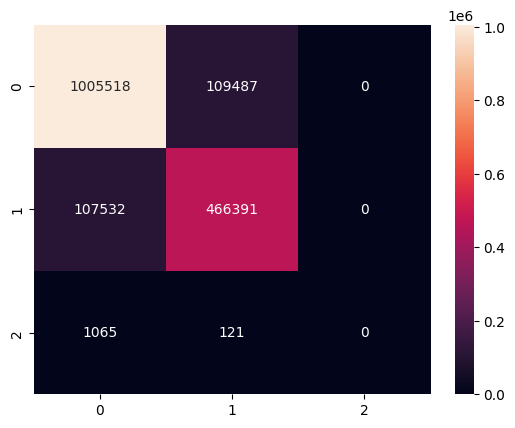

In [23]:
preds = predictions.select("label", "prediction").toPandas()
conf = confusion_matrix(preds["label"], preds["prediction"])
sns.heatmap(conf, annot=True, fmt="d")

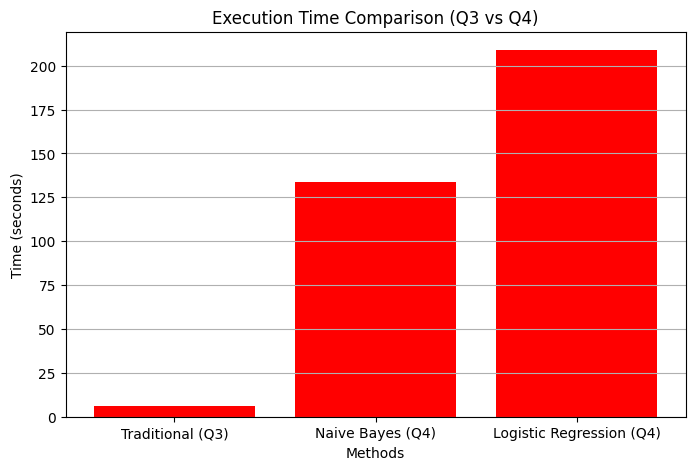

In [24]:
methods = ['Traditional (Q3)', 'Naive Bayes (Q4)', 'Logistic Regression (Q4)']
times = [6.25, 133.64, 208.88]

plt.figure(figsize=(8, 5))
plt.bar(methods, times, color='red')
plt.xlabel("Methods")
plt.title("Execution Time Comparison (Q3 vs Q4)")
plt.ylabel("Time (seconds)")
plt.grid(axis='y')
plt.show()

In [25]:
spark.stop()